# SARIMA

The purpose of this notebook is to run SARIMA modesl on our target variable, which is mortality due to heart attack per 100K per year (per state).

In [1]:
import pickle
import pandas as pd
import numpy as np
import itertools
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import warnings
import math

from progress_bar import log_progress

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250

In [3]:
# my own helper functions
import sarimax_helper_functions
from sarimax_helper_functions import evaluate_arimax_model_using_forecasting, evaluate_arimax_model_using_prediction, get_test_forecast_from_arimax_with_params, get_test_prediction_from_arimax_with_params, make_arimax_model_with_params, make_all_possible_param_dictionaries

In [4]:
with open("../data/pickles/cardiac_mortality_obesity_dm_df_by_state.pkl", "rb") as picklefile:
    state_mortality_dict = pickle.load(picklefile)

We'll take a look at California first, and then we can look at other states.

In [16]:
california_df = state_mortality_dict['California']

In [17]:
california_df.dropna(inplace=True)

We'll do a brute force search to see which p, d, q and P, D, Q parameters generate the best prediction for California.

In [18]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [19]:
param_choices = {}
param_choices['order'] = pdq
param_choices['seasonal'] = seasonal_pdq
param_choices['trend'] = ['c', 'ct', 't', 'n']
param_choices['enforce_stationarity'] = [True, False]
param_choices['enforce_invertibility'] = [True, False]

In [20]:
list_of_SARIMA_dicts = make_all_possible_param_dictionaries(param_choices=param_choices)

We'll use a helper method I wrote that basically takes a set of parameters for a SARIMA model, then takes a time series and splits it up into a train fraction and a test fraction (default train fraction is 0.66, but you can set it manually), fits a model with the given parameters, and then returns the AIC for that model. It also produces a forecast that is the same length as the test fraction, and then it returns the RMSE for the error between the model's forecast and the actual values of the target in the test fraction.

In [22]:
california_forecast_AIC_RMSE = []

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_SARIMA_dicts), every=1, size=len(list_of_SARIMA_dicts)):
    try:
        aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, california_df['mortality_per_100k'])
        california_forecast_AIC_RMSE.append((index, aic, test_rmse))
    except:
        pass

We'll then turn the list of tuples that we got into a dataframe, which we can sort to see which parameters gave us the lowest forecast RMSE on the test fraction.

In [23]:
california_pdq_AIC_RMSE_df = pd.DataFrame(california_forecast_AIC_RMSE, columns=['parameter_dict_number', 'aic', 'forecast_test_mse'])
california_pdq_AIC_RMSE_df.set_index('parameter_dict_number', inplace=True)

In [29]:
california_pdq_AIC_RMSE_df.sort_values(by='aic').head(5)

,aic,forecast_test_mse
parameter_dict_number,,
562,-55.505919,0.437797
563,-55.505918,0.437804
754,-55.386906,0.424465
755,-55.386905,0.424465
567,-53.462436,0.468025


In [25]:
best_by_aic = list(california_pdq_AIC_RMSE_df.sort_values(by='aic').head(10).index)
best_by_aic

[562, 563, 754, 755, 567, 979, 978, 242, 243, 690]

In [26]:
for num in best_by_aic:
    print(list_of_SARIMA_dicts[num])

{'order': (1, 0, 0), 'seasonal': (0, 1, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': True}
{'order': (1, 0, 0), 'seasonal': (0, 1, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 0, 1), 'seasonal': (1, 1, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': True}
{'order': (1, 0, 1), 'seasonal': (1, 1, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 0, 0), 'seasonal': (0, 1, 1, 12), 'trend': 'ct', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 1, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 1, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': True}
{'order': (0, 0, 1), 'seasonal': (1, 1, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': True}
{'o

In [28]:
california_pdq_AIC_RMSE_df.sort_values(by='forecast_test_mse').head(5)

,aic,forecast_test_mse
parameter_dict_number,,
857,25.986410,0.141944
722,-48.208678,0.142857
723,-48.493744,0.146954
991,-50.283207,0.148136
990,-50.280714,0.148194


In [48]:
best_by_mse = list(california_pdq_AIC_RMSE_df.sort_values(by='forecast_test_mse').head(5).index)
best_by_mse

[857, 722, 723, 991, 990]

In [49]:
for num in best_by_mse:
    print(list_of_SARIMA_dicts[num])

{'order': (1, 1, 0), 'seasonal': (1, 0, 1, 12), 'trend': 't', 'enforce_stationarity': True, 'enforce_invertibility': False}
{'order': (1, 0, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': True}
{'order': (1, 0, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 1, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'n', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 1, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'n', 'enforce_stationarity': False, 'enforce_invertibility': True}


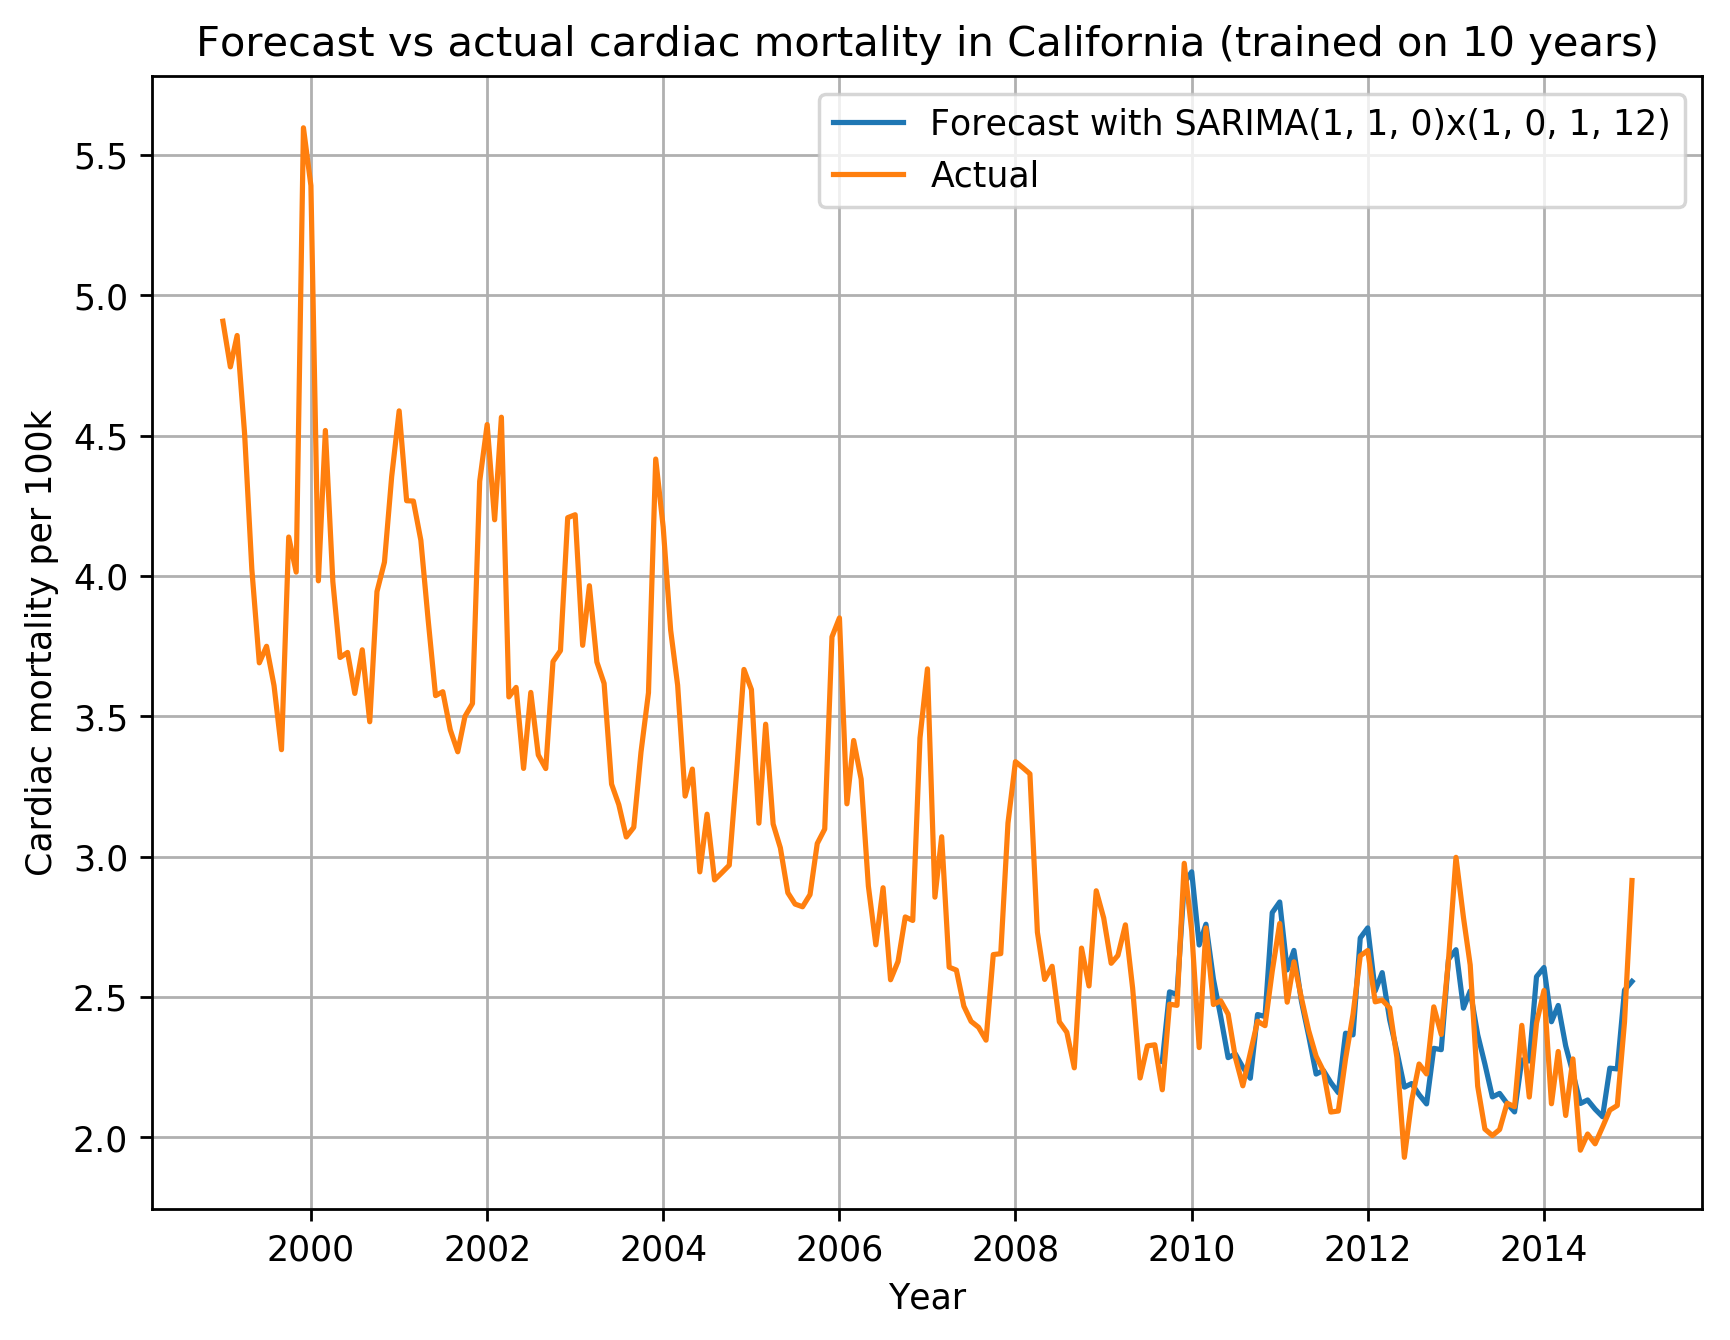

In [64]:
test_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], california_df.mortality_per_100k)

plt.plot(test_forecast, label=f"Forecast with SARIMA{list_of_SARIMA_dicts[best_by_mse[0]]['order']}x{list_of_SARIMA_dicts[best_by_mse[0]]['seasonal']}")
plt.plot(california_df['mortality_per_100k'], label="Actual")

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100k")
plt.title("Forecast vs actual cardiac mortality in California (trained on 10 years)", y = 1.02)

plt.grid()
plt.legend()

plt.savefig("../figures_2/california_forecast_SARIMA_10y.png")

plt.show()

With SARIMA/ARIMA models, we can choose to either make step by step predictions (that is, only predicting next month's value, one month at a time), or we can make the model forecast. Not surprisingly, the parameters that were best for forecasting do well at predicting one time step ahead as well, as we can see in the plot below.

In [58]:
california_prediction = get_test_prediction_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], california_df['mortality_per_100k'], train_fraction=0.66)

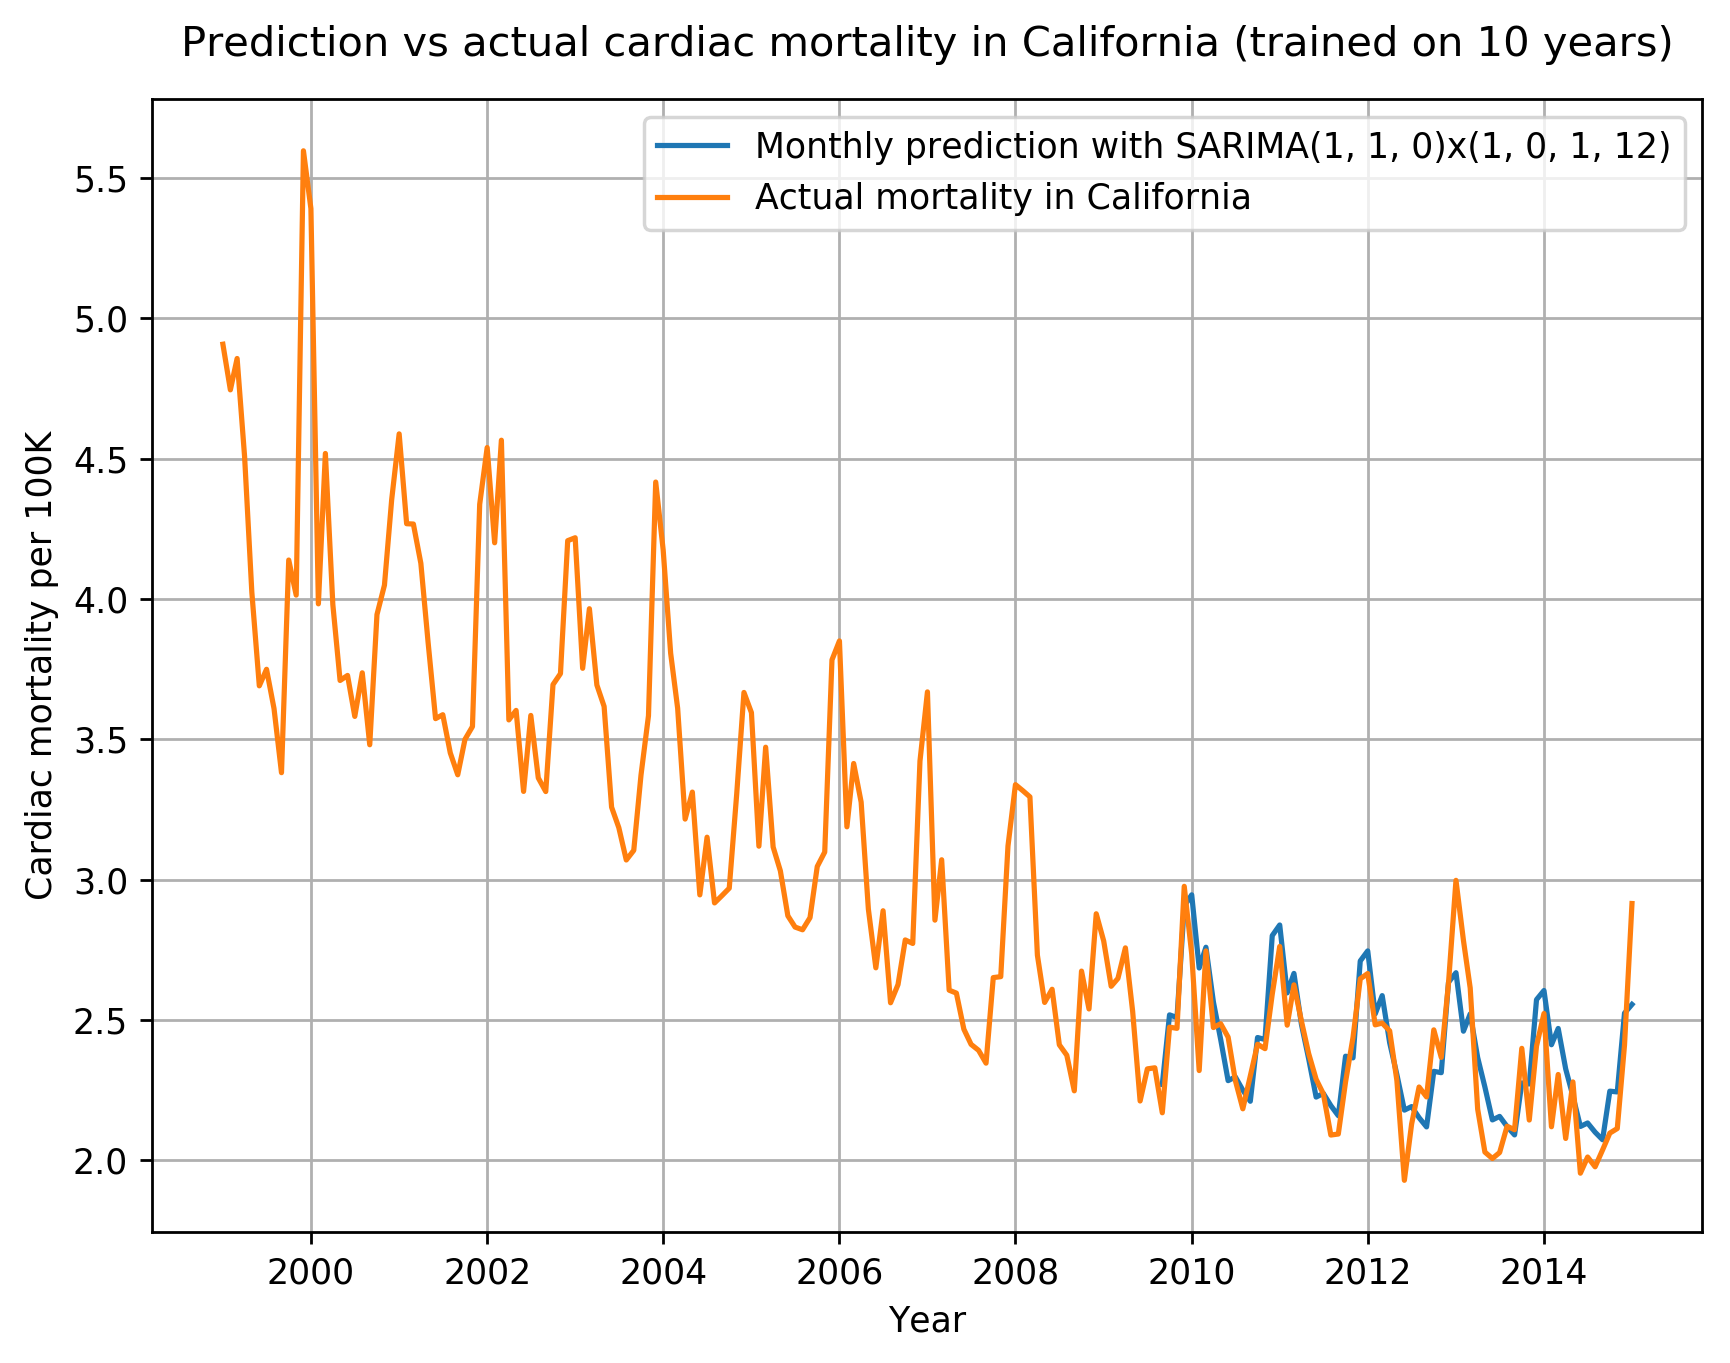

In [60]:
plt.plot(california_prediction, label = f"Monthly prediction with SARIMA{list_of_SARIMA_dicts[best_by_mse[0]]['order']}x{list_of_SARIMA_dicts[best_by_mse[0]]['seasonal']}")
plt.plot(california_df['mortality_per_100k'], label = "Actual mortality in California")

plt.title("Prediction vs actual cardiac mortality in California (trained on 10 years)", y = 1.02)

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")

plt.grid()
plt.legend()

plt.show()

The quality of the forecast is heavily dependent how much of the data it has trained on, or what data it sees when it trained. When we did gridsearch on all combinations of p,d,q and P,D,Q with the values of 0 or 1, that was with the default training fraction of 0.66 (which translates into about 10 years worth of data). If we change the training fraction (e.g. if we set the training fraction to 0.6, which is 9 years worth of data, or to 0.75, which is 11 years worth of data, then the forecasts aren't as good.

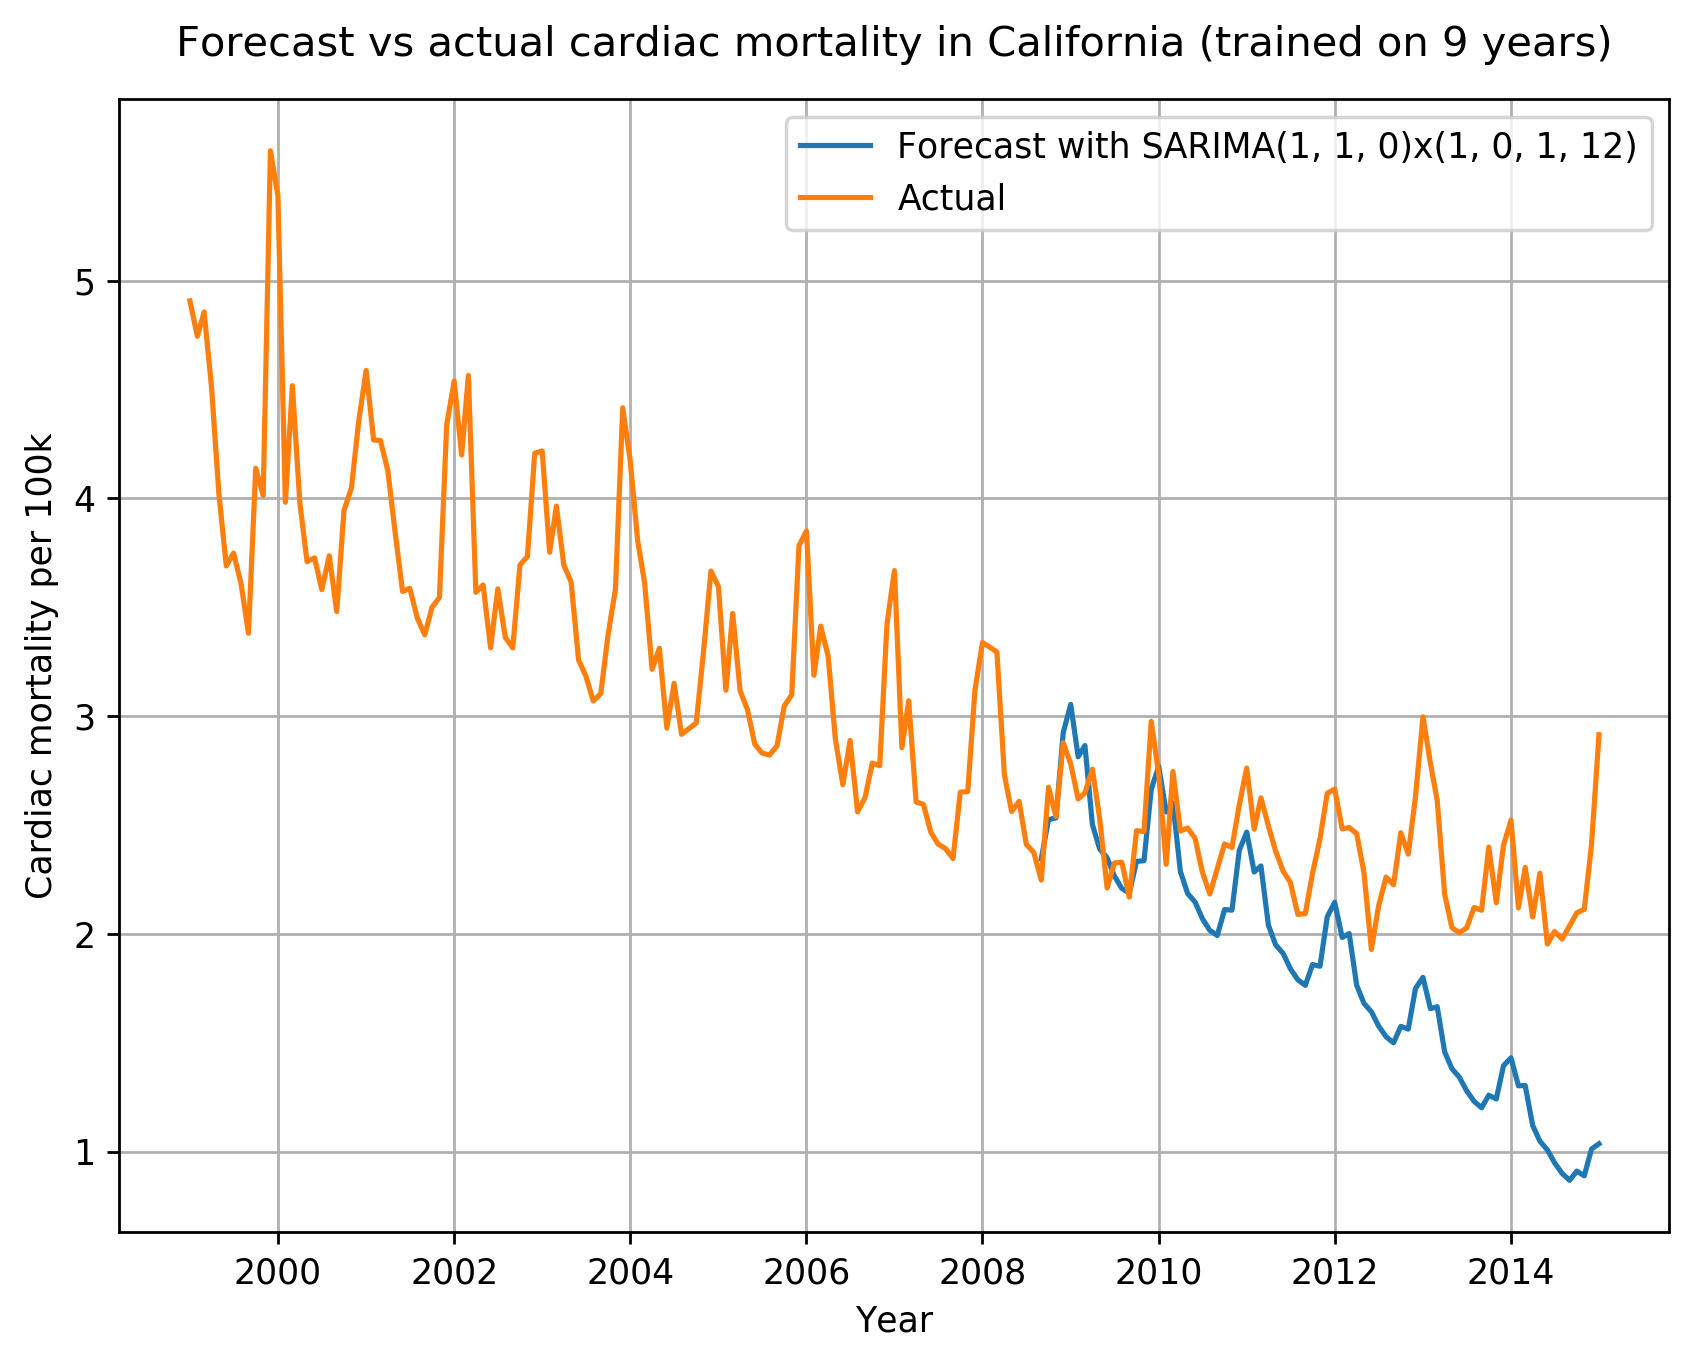

In [81]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], california_df['mortality_per_100k'], train_fraction=0.6)

plt.plot(california_forecast, label=f"Forecast with SARIMA{list_of_SARIMA_dicts[best_by_mse[0]]['order']}x{list_of_SARIMA_dicts[best_by_mse[0]]['seasonal']}")
plt.plot(california_df['mortality_per_100k'], label="Actual")

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100k")
plt.title("Forecast vs actual cardiac mortality in California (trained on 9 years)", y = 1.02)

plt.grid()
plt.legend()

plt.savefig("../figures_2/california_forecast_SARIMA_9y.png")

plt.show()

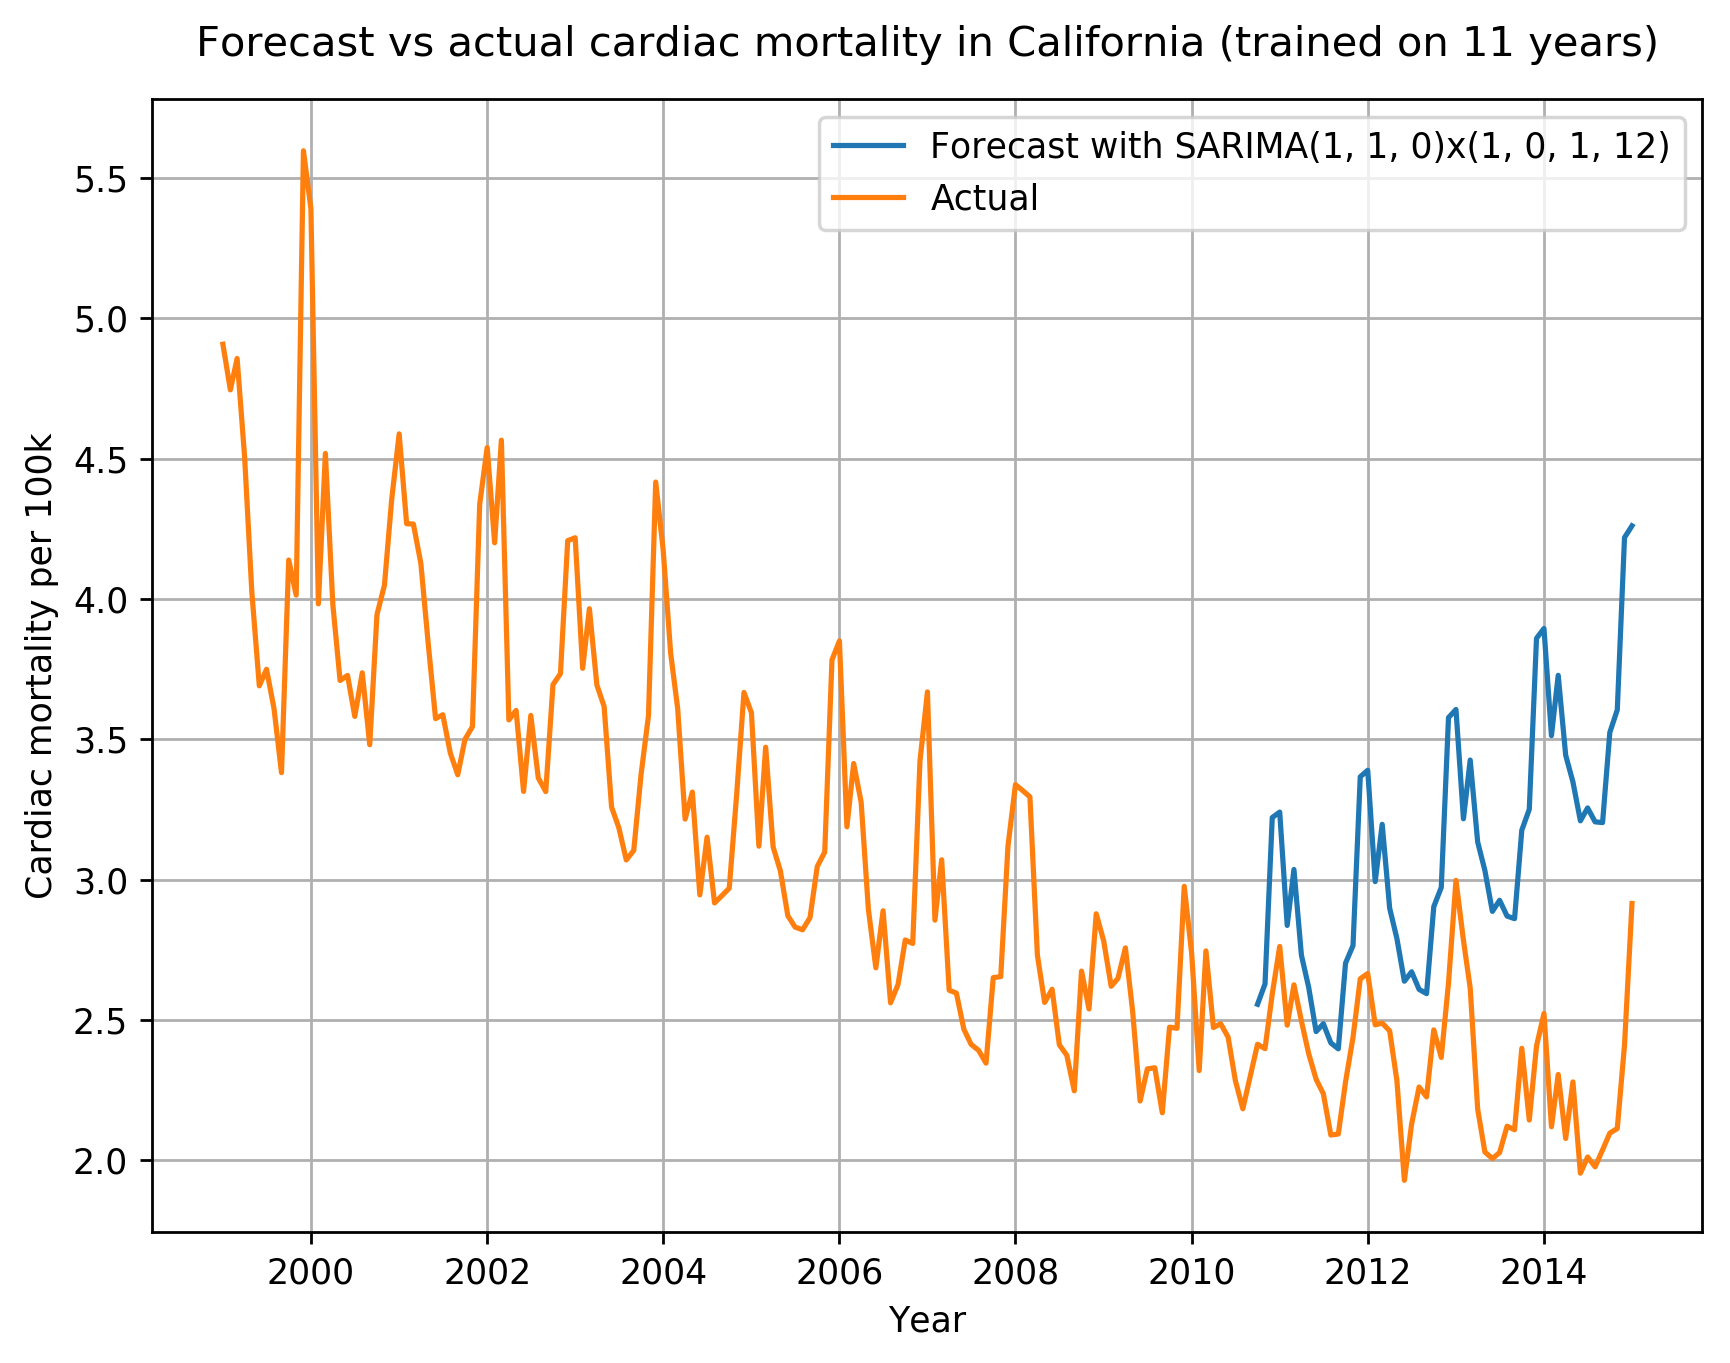

In [82]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], california_df['mortality_per_100k'], train_fraction=0.73)

plt.plot(california_forecast, label=f"Forecast with SARIMA{list_of_SARIMA_dicts[best_by_mse[0]]['order']}x{list_of_SARIMA_dicts[best_by_mse[0]]['seasonal']}")
plt.plot(california_df['mortality_per_100k'], label="Actual")

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100k")
plt.title("Forecast vs actual cardiac mortality in California (trained on 11 years)", y = 1.02)

plt.grid()
plt.legend()

plt.savefig("../figures_2/california_forecast_SARIMA_11y.png")

plt.show()

Let's try the parameters that produced the best forecasts for California on other states and see how well these forecast.

In [132]:
state = 'New York'

state_df = state_mortality_dict[state]
state_df.dropna(inplace=True)

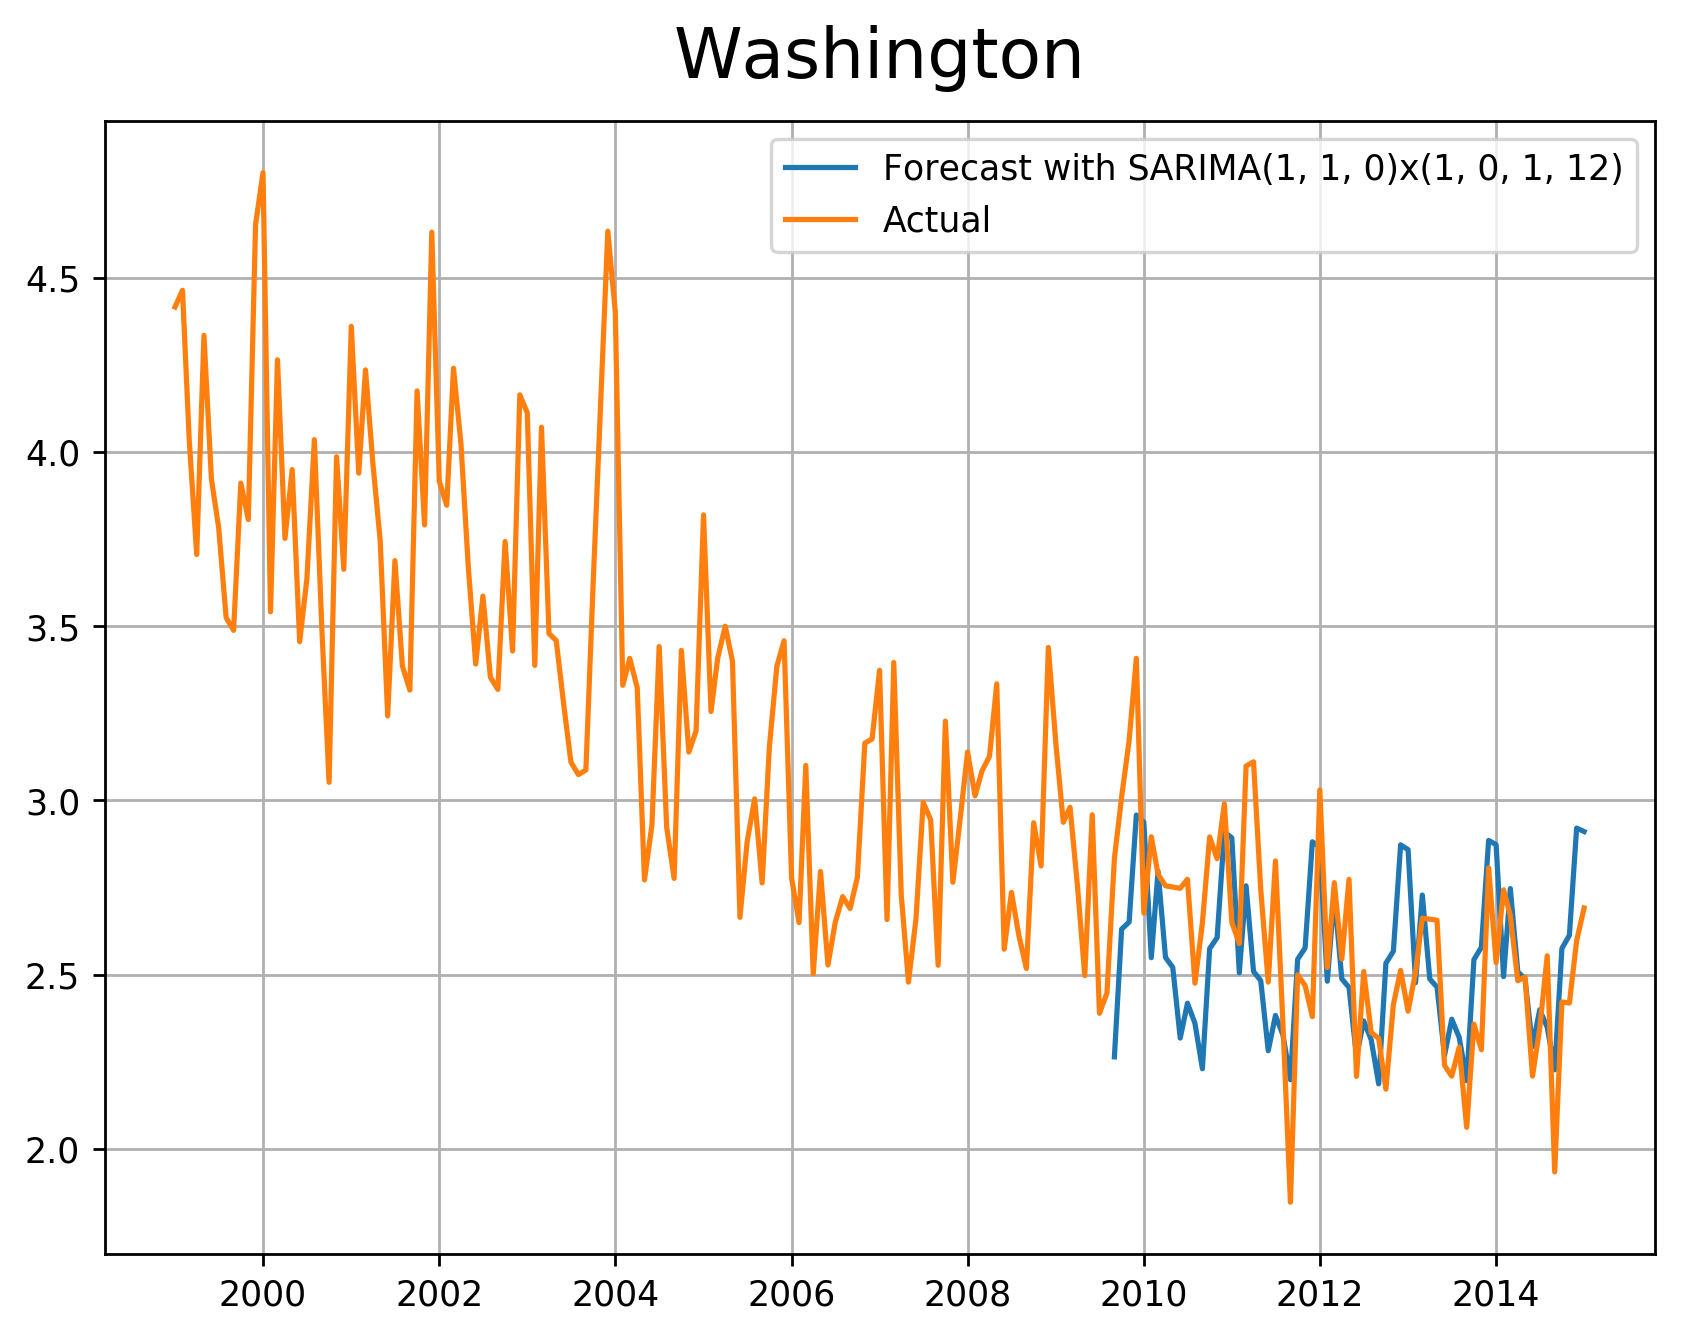

In [133]:
state_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[best_by_mse[0]], state_df['mortality_per_100k'])

plt.plot(state_forecast, label=f"Forecast with SARIMA{list_of_SARIMA_dicts[best_by_mse[0]]['order']}x{list_of_SARIMA_dicts[best_by_mse[0]]['seasonal']}")
plt.plot(state_df['mortality_per_100k'], label="Actual")

# plt.xlabel("Year")
# plt.ylabel("Cardiac mortality per 100k")
plt.title(f"{state}", y = 1.02, fontsize=20)

plt.grid()
plt.legend()
state_name = state.lower().replace(" ", "_")
plt.savefig(f"../figures_2/{state_name}_forecast_SARIMA_10y.png", transparent=True)

plt.show()